In [1]:
%load_ext autoreload
%autoreload 2

In [174]:
import numpy as np
import matplotlib.pylab as plt
from skimage import io
from skimage.data import rocket
from skimage.transform import rotate

In [3]:
import stretchablecorr as sc

### Error estimation

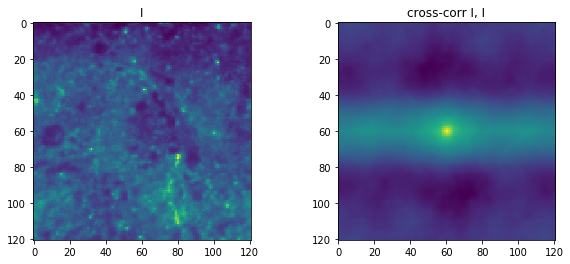

In [161]:
# see https://en.wikipedia.org/wiki/Perlin_noise#/media/File:Perlin.png
I0 = io.imread('./images/PerlinNoise2D.png').mean(axis=2).astype(np.float64)
I0 = io.imread('./images/HS2/01p600146.TIF').astype(np.float64)
#I = (I - np.min(I) )/np.std(I)
#I = io.imread('./images/PDMS_Amazon_18juin/output_0017.tiff')[100:300, 100:305].mean(axis=2)


window_half_size = 60
I, ij = sc.crop(I0, [500, 500], window_half_size)

#I = I[::3, ::3]
# plt.imshow(I); plt.title('Perlin noise');
dx_span, dy_span, phase_corr, res = sc.output_cross_correlation(I, I,
                                                                upsamplefactor=1, phase=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.imshow(I); ax1.set_title('I');
ax2.imshow(phase_corr);  ax2.set_title('cross-corr I, I');


In [162]:

def construct_key(p):
    name = f"{p['window_half_size']}px"
    if p['coarse_search']:
        name += ' coarse'
    if p['phase']:
        name += ' phase'
    else:
        name += ' CC'
    name += ' ' + p['method']
    return name

In [163]:
def sample_one(A, B, sigma, params):    
    B_prime = B + sigma*np.std(B)*np.random.randn(*B.shape)
    x, y = np.array(A.T.shape)/2
    u, errors = sc.get_shifts(A, B_prime, x, y, **params)
    return u, errors

In [164]:
def sample_N(A, B, sigma, params, N):
    errors = []
    displ = []
    for _ in range(N):
        for sigma in sigma_span:
            try:
                u, err = sample_one(A, B, sigma, params)
                errors.append(err)
                displ.append(u)
            except ValueError as e:
                print(e)
                break
                pass
        
    return np.array(displ), np.array(errors)

In [165]:
def avg_radius(u):
    d = np.sqrt(np.sum((u-u.mean(axis=0))**2, axis=1))
    return d.mean()

In [179]:
params = {'window_half_size': 35,
          'coarse_search':False,
          'phase': False,
          'method':'opti' }

sigma_span = np.logspace(-1, 1, 10)

J = rotate(I, 5, center=None)
displ, errors = sample_N(I, J, sigma_span, params, 150)

displ = np.sqrt(np.sum(displ**2, axis=1))

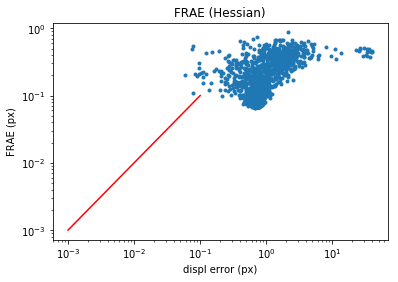

In [180]:
plt.title('FRAE (Hessian)')
plt.loglog(displ, np.sqrt(np.abs(errors[:, 1])), '.')
plt.loglog([1e-3, 1e-1], [1e-3, 1e-1], '-r')
plt.xlabel('displ error (px)');
plt.ylabel('FRAE (px)');

x_opt: [-0.00340914  0.002032  ]


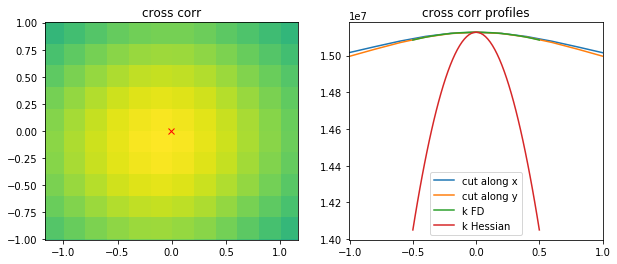

In [208]:
#  look at the CC
window_half_size = 10
A0, ij = sc.crop(I, np.array(np.shape(I))/2, window_half_size)

sigma = 0.05
B0 = A0 + sigma*np.std(A0)*np.random.randn(*A0.shape)

zoom_factor = 0.1
dx_span, dy_span, cross_corr, res = sc.output_cross_correlation(A0, B0,
                                                                upsamplefactor=5, phase=False)
x_opt = -res.x

argmax_idx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
argmax_idx_cc = argmax_idx

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.pcolor(dx_span, dy_span, np.log(cross_corr))
ax1.plot(*x_opt[::-1], 'xr'); 
ax1.axis('equal');
print('x_opt:', x_opt[::-1])
zoom_lim = int( zoom_factor*A0.shape[0]/2 )
ax1.set_title('cross corr');
ax1.set_xlim(np.array([-zoom_lim, zoom_lim]) + x_opt[::-1]);
ax1.set_ylim(np.array([-zoom_lim, zoom_lim]) + x_opt[::-1]);

ax2.set_title('cross corr profiles');
ax2.plot(dy_span, cross_corr[argmax_idx[0], :], label='cut along x');
ax2.plot(dx_span, cross_corr[:, argmax_idx[1]], label='cut along y'); ax2.legend();
ax2.set_xlim(np.array([-zoom_lim, zoom_lim]) + x_opt[::-1]);


ky = -(cross_corr[argmax_idx[0]+1, argmax_idx[1]] +\
      cross_corr[argmax_idx[0]-1, argmax_idx[1]] -\
      2*cross_corr[argmax_idx[0], argmax_idx[1]] )/np.diff(dy_span).mean()**2
    
x_peak = np.linspace(-0.5, 0.5, 55)
y = np.max(cross_corr) - 0.5*ky*x_peak**2
ax2.plot(x_peak, y, label='k FD'); ax2.legend();

H = np.linalg.inv(res.hess_inv)
x_peak = np.linspace(-0.5, 0.5, 55)
y = np.max(cross_corr) - 0.5*H[0, 0]*x_peak**2
ax2.plot(x_peak, y, label='k Hessian'); ax2.legend();

In [198]:
ky

-338597.41929061705

In [100]:
A = A.astype(np.float64)
B = A + 1e3 + 10*np.random.randn(*A.shape)
a = np.mean(A)
b = np.mean(B)
print(a, b)

1521.6638905413445 2521.808785913234


In [101]:
np.var(A - B)

101.43219112431646

In [102]:
np.mean( ((A-B) - np.mean(A-B))**2 )

101.43219112431646

In [103]:
np.mean( (A-B)**2 + np.mean(A-b)**2 - 2*(A-B)*np.mean(A-B) )

101.43219112426861

In [104]:
np.mean((A-B)**2) - (a-b)**2

101.43219112465158

In [105]:
np.mean(A**2 + B**2 - 2*A*B) - (a-b)**2

101.43219112465158

In [106]:
np.mean(A**2 + B**2 - 2*A*B) - (a-b)**2

65535

In [98]:
A**2

array([[52129,  8516, 37952, ..., 42425, 34201, 28164],
       [14249, 51748, 35904, ..., 55849, 28537, 60228],
       [23492,  4804, 58916, ..., 50468, 48481,  6801],
       ...,
       [12129, 55337, 31248, ..., 17761, 14073,  3201],
       [62468,  1337, 24273, ..., 10340,  9297, 46441],
       [51793, 35457, 13217, ..., 44772, 33792,  8256]], dtype=uint16)

In [73]:
np.mean(A**2 + B_prime**2) - 2*np.max(phase_corr)/A.size

-2287357.461206272

In [94]:
u = np.random.randn(100, 10)
v = np.random.randn(100, 10)
print( np.mean( (u-v)**2 ) )
print( np.mean(u**2 + v**2 - 2*u*v) )

2.008148825141083
2.008148825141083


In [81]:
np.mean(A**2 + B**2) + 2*np.mean(A*B) - (a-b)**2

14513416.65905079

In [75]:
np.max(phase_corr)/A.size

2759972.896592462

In [79]:
np.mean(A*B)

4319450.148772621

In [29]:
np.mean((A-a)**2 + (B-b)**2) - 2*np.max(phase_corr)/A.size

-4119862.4137546774

In [131]:
dx_span, dy_span, auto_corr, res = sc.output_cross_correlation(A, A, upsamplefactor=1, phase=False)


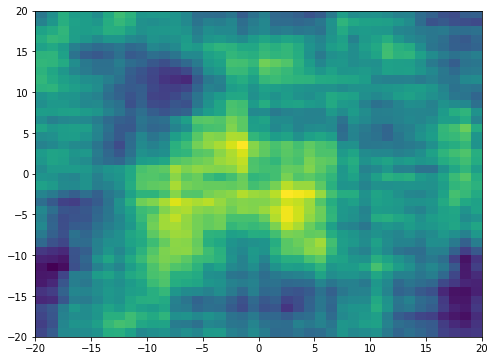

In [132]:
plt.figure(figsize=(8, 6))
plt.pcolor(dx_span, dy_span, phase_corr-auto_corr);

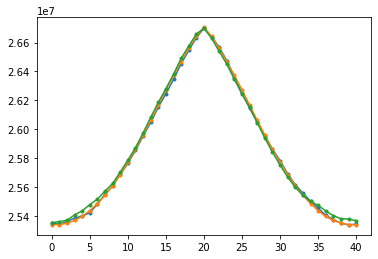

In [129]:
plt.plot(phase_corr[:, argmax_idx[1]], '.-')
plt.plot(auto_corr[:, argmax_idx[1]], '.-')
plt.plot(phase_corr[argmax_idx[0], :], '.-')

## compute averages

In [141]:
stored_results = {}

In [142]:
params = {'window_half_size': 20,
          'coarse_search':False,
          'phase': False,
          'method':'opti' }

sigma_span = np.logspace(-1, 1, 20)
results = {'params':params,
           'avg_radius':[],
           'mean_errors':[]}

for sigma in sigma_span:
    print('sigma:', sigma, end='\r')
    displ, errors = sample_N(I, I, sigma, params, 100)
    results['avg_radius'].append( avg_radius(displ) )
    results['mean_errors'].append( errors.mean(axis=0) )
    
results['avg_radius'] = np.array(results['avg_radius'])
results['mean_errors'] = np.vstack(results['mean_errors']) 

stored_results[construct_key(results['params'])] = results

IndexError: index 2 is out of bounds for axis 1 with size 2

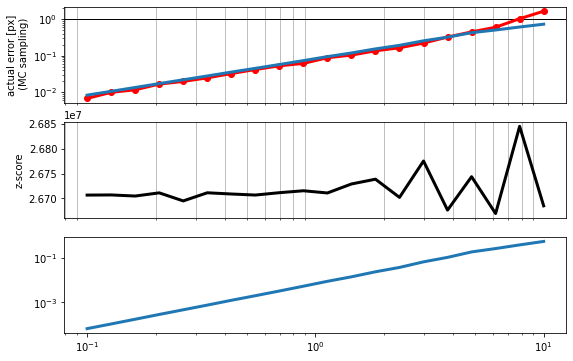

In [144]:
for results in stored_results.values():

    # Graph
    linewidth = 3
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9,6))
    
    ax1.axhline(y=1, color='black', linewidth=1)
    ax1.loglog(sigma_span, results['avg_radius'], '-o', label='truth (MC)', linewidth=linewidth, color='red')
    ax1.set_ylabel('actual error [px]\n (MC sampling)')
    ax1.loglog(sigma_span, np.sqrt(results['mean_errors'][:, 1]), linewidth=linewidth)
    
    ax1.set_xticks([])
    ax1.grid(axis='x', which='both')
    
    ax2.semilogx(sigma_span, results['mean_errors'][:, 0], linewidth=linewidth, color='black')
    ax2.set_ylabel('z-score');
    ax2.set_xticks([])
    ax2.grid(axis='x', which='both');
    
    ax3.loglog(sigma_span, results['mean_errors'][:, 1], linewidth=linewidth)
    ax3.loglog(sigma_span, results['mean_errors'][:, 2], linewidth=linewidth)
    ax3.set_ylabel('FRAE [px]');
    ax3.grid(axis='x', which='both')
    
    ax1.set_xlim([min(sigma_span), max(sigma_span)])
    ax2.set_xlim([min(sigma_span), max(sigma_span)])
    ax3.set_xlim([min(sigma_span), max(sigma_span)])
    plt.xlabel('sigma - noise level');
    
    ax1.set_title(construct_key(results['params']));
    

Cl:
- CC is at least one of order of magnitude better than phase-corr
- z-score works when errors > 1px, saturate below
- FRAE is strange...

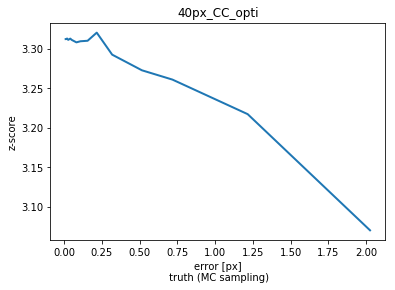

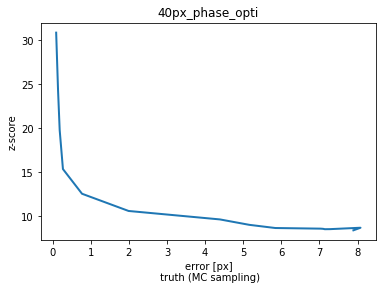

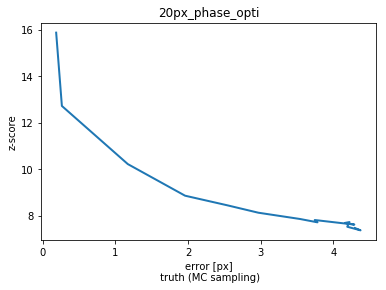

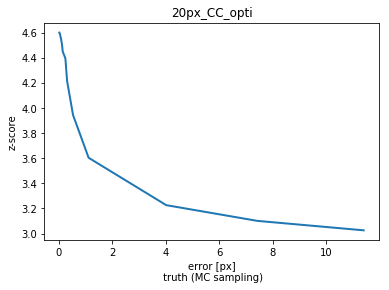

In [138]:
for results in stored_results.values():

    # Graph
    linewidth=2
    plt.figure();
    plt.xlabel('error [px]\n truth (MC sampling)')

    plt.plot(results['avg_radius'], results['mean_errors'][:, 0], linewidth=linewidth)
    plt.ylabel('z-score');
    plt.title(construct_key(results['params']));

## Draft

In [ ]:
def estimate(window_half_size, sigma, phase, N=100):
    dxy_err = np.vstack([sample(window_half_size, sigma=sigma, phase=phase) for _ in range(N)])
    dxy = dxy_err[:, :2]
    eps_MC = np.sqrt(np.sum((dxy - dxy.mean(axis=0))**2, axis=1)).mean()
    
    err_estimate = dxy_err[:, 2]
    
    return eps_MC, err_estimate[0]

sigma_span = np.logspace(-1, 3, 15)
errs = np.vstack([estimate(10, s, phase=True, N=100) for s in sigma_span])

fig, (ax1, ax2) = plt.subplots(2, )
plt.title('phase opti')
ax1.semilogx(sigma_span, errs[:, 1], label='estimate')
ax1.set_ylabel('z-score');
ax2.semilogx(sigma_span, errs[:, 0],  '-o', label='true (MC)');
ax2.set_ylabel('shift error [px]');
plt.legend(); 
plt.xlabel('noise level');

In [15]:
cube, image_names = sc.load_image_sequence('./images/HS2_01/')

FileNotFoundError: [Errno 2] No such file or directory: './images/HS2_01/'

In [384]:
def custom_entropy(A):
    p = (A - A.min())/A.ptp()
    p = p/np.sum(p)
    p = p[p>0]
    return -np.sum( p*np.log(p) )/np.log(A.size)

def scd_moment(A, x, y):
    i, j = np.arange(A.shape[0]), np.arange(A.shape[1])
    i_grid, j_grid = np.meshgrid(i, j)
    pi = (i_grid - y)**2
    pj = (j_grid - x)**2
    d = np.sqrt(pi + pj)
    return np.average(d, weights=A)

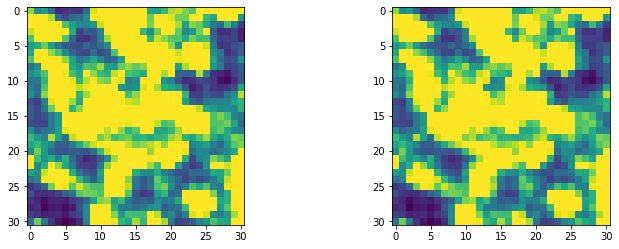

In [667]:
I = cube[20]

window_half_size = 15
A, ij = sc.crop(I, (222, 150), window_half_size)
B, ij = sc.crop(I+4, (222, 150), window_half_size)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(A);
ax2.imshow(B);

In [673]:
dx_span, dy_span, phase_corr, res = sc.output_cross_correlation(A, B, upsamplefactor=5, phase=False)
displ, err = get_shifts(A, B, *np.array(A.shape)/2,
           window_half_size=14,
           coarse_search=False,
           phase=False,
           method='opti')

plt.pcolor(dx_span, dy_span, phase_corr);
plt.plot(*displ[::-1], 'rx')
plt.colorbar(); plt.axis('equal');

In [467]:
i_grid, j_grid = np.meshgrid(dy_span, dx_span)
pi = (i_grid - dy)**2
pj = (j_grid - dx)**2
d = np.sqrt(pi + pj)**(1/2)
print(np.average(d, weights=np.log(phase_corr)-np.log(phase_corr).min()))
print('f   ', res.fun)
print('max ', phase_corr.max())
print('mean', phase_corr.mean())
print('std ', phase_corr.std())
print((phase_corr.max() - phase_corr.mean())/phase_corr.std())
print(scd_moment(phase_corr, dx, dy))

4.4203375858590634
f    -17035622601.999994
max  17035622601.999998
mean 15998583783.782854
std  88576968.00457875
11.707770559086386
46.024437021676604


In [303]:
A = np.zeros(shape)+1
A[10, 10] = 2
B = np.zeros(shape)+1
B[15, 15] = 3

In [441]:
shape = (61, 61)
A = np.random.randn(*shape)
B = np.random.randn(*shape)#np.ones_like(A)
print(np.sum(A))

-97.01070422882496


In [468]:
ddx = np.diff(phase_corr, axis=0)
ddy = np.diff(phase_corr, axis=1)

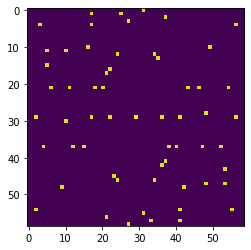

In [472]:
mask_x = np.sign( ddx[:-1, :] ) > np.sign( ddx[1:, :] )

mask_y = np.sign( ddy[:, :-1] ) > np.sign( ddy[:, 1:] )

peaks = mask_x[:, 1:-1]&mask_y[1:-1]
phase_corr_peak = phase_corr[1:-1, 1:-1].copy()
phase_corr_peak[~peaks] = 0
plt.imshow(phase_corr_peak);

In [470]:
from skimage.morphology import local_maxima

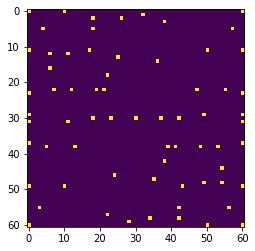

In [471]:
plt.imshow( local_maxima(phase_corr) )

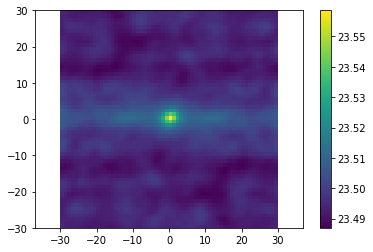

In [406]:
plt.pcolor(dx_span, dy_span, np.log(phase_corr));
plt.colorbar(); plt.axis('equal');

In [270]:
get_shifts(A, B, *np.array(A.shape)/2,
           window_half_size=14,
           coarse_search=False,
           phase=False,
           method='opti')

(5.0, 5.0, 4.078367216923564e-05)

In [32]:
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=5,
           coarse_search=False,
           method='opti')

(-0.05032008353871891, 1.224788309697461, -7.20748837107242)

In [527]:
def sample(window_half_size, sigma, phase):    
    B_prime = B + sigma*np.std(B)*np.random.randn(*B.shape)
    x, y = np.array(A.T.shape)/2
    dx, dy, err = get_shifts(A, B_prime, x, y,
                             window_half_size=window_half_size,
                             coarse_search=False,
                             phase=phase,
                             method='opti')
    return dx, dy, err

def estimate(window_half_size, sigma, phase, N=100):
    dxy_err = np.vstack([sample(window_half_size, sigma=sigma, phase=phase) for _ in range(N)])
    dxy = dxy_err[:, :2]
    eps_MC = np.sqrt(np.sum((dxy - dxy.mean(axis=0))**2, axis=1)).mean()
    
    err_estimate = dxy_err[:, 2]
    
    return eps_MC, err_estimate[0]

sigma_span = np.logspace(-1, 3, 15)
errs = np.vstack([estimate(10, s, phase=True, N=100) for s in sigma_span])

fig, (ax1, ax2) = plt.subplots(2, )
plt.title('phase opti')
ax1.semilogx(sigma_span, errs[:, 1], label='estimate')
ax1.set_ylabel('z-score');
ax2.semilogx(sigma_span, errs[:, 0],  '-o', label='true (MC)');
ax2.set_ylabel('shift error [px]');
plt.legend(); 
plt.xlabel('noise level');

In [480]:
sigma_span = np.logspace(-1, 2, 15)
errs = np.vstack([estimate(15, s, phase=False, N=100) for s in sigma_span])

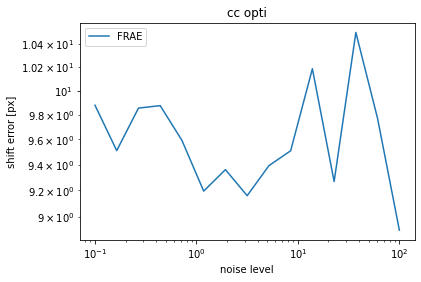

In [481]:
plt.title('cc opti')
plt.loglog(sigma_span, 1/errs[:, 1], label='FRAE')
#plt.semilogx(sigma_span, errs[:, 0],  '-o', label='true (MC)');
plt.legend(); plt.ylabel('shift error [px]'); plt.xlabel('noise level');

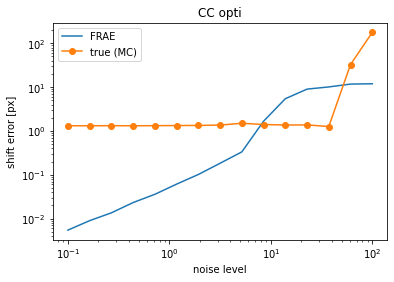

In [100]:
sigma_span = np.logspace(-1, 2, 15)
errs = np.vstack([estimate(15, s, phase=False, N=100) for s in sigma_span])

plt.title('CC opti')
plt.loglog(sigma_span, errs[:, 0], label='FRAE')
plt.loglog(sigma_span, errs[:, 1],  '-o', label='true (MC)');
plt.legend(); plt.ylabel('shift error [px]'); plt.xlabel('noise level');

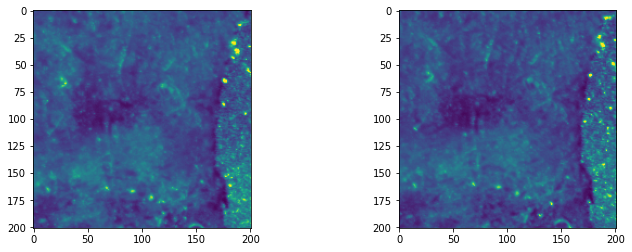

In [621]:
I = cube[0]
J = cube[10]
window_half_size = 100
x, y = 100, 106
A, ij = sc.crop(I, (x, y), window_half_size)
B, ij = sc.crop(J, (x, y), window_half_size)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(A);
ax2.imshow(B);

In [628]:
window_half_size_span = np.arange(5, 70, 5)
res = [get_shifts(I, J, x, y,
           window_half_size=whs,
           coarse_search=True,
           phase=True,
           method='opti')
      for whs in window_half_size_span]

In [629]:
err = [row[1] for row in res]
err = np.vstack(err)

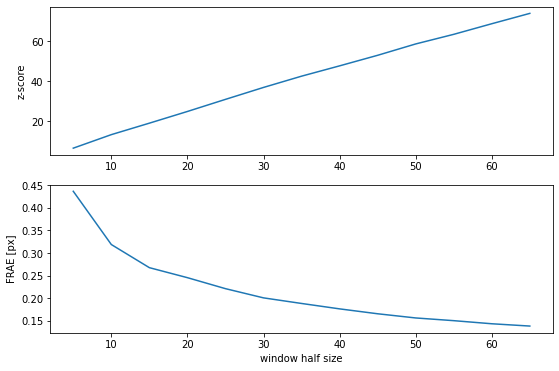

In [630]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,6))
ax1.plot(window_half_size_span, err[:, 0]);
ax2.plot(window_half_size_span, err[:, 1]);

ax1.set_ylabel('z-score');
ax2.set_ylabel('FRAE [px]');
plt.xlabel('window half size');

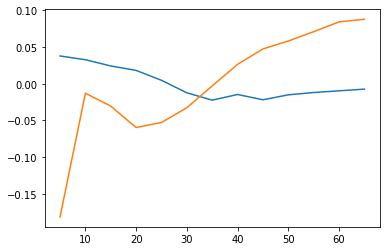

In [581]:
plt.plot(window_half_size_span, res[:, 0]-res[:, 0].mean());
plt.plot(window_half_size_span, res[:, 1]-res[:, 1].mean());

z_score 7.659085622138768


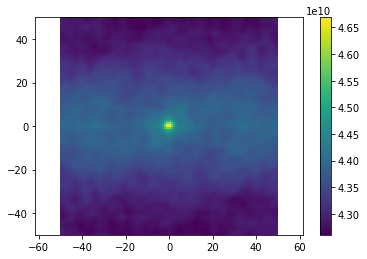

In [499]:
window_half_size = 50
A, ij = sc.crop(I, (232, 150), window_half_size)
B, ij = sc.crop(J, (232, 150), window_half_size)
dx_span, dy_span, phase_corr, res = sc.output_cross_correlation(A, B, upsamplefactor=1, phase=False)
print('z_score', (phase_corr.max()-phase_corr.mean())/phase_corr.std())
plt.pcolor(dx_span, dy_span, phase_corr);
plt.colorbar(); plt.axis('equal');

In [494]:
def sample(window_half_size, sigma, phase):    
    x, y = np.array(A.T.shape)/2
    dx, dy, err = get_shifts(A, B_prime, x, y,
                             window_half_size=window_half_size,
                             coarse_search=False,
                             phase=phase,
                             method='opti')
    return dx, dy, err

def estimate(window_half_size, sigma, phase, N=100):
    dxy_err = np.vstack([sample(window_half_size, sigma=sigma, phase=phase) for _ in range(N)])
    dxy = dxy_err[:, :2]
    eps_MC = np.sqrt(np.sum((dxy - dxy.mean(axis=0))**2, axis=1)).mean()
    
    err_estimate = dxy_err[:, 2]
    
    return eps_MC, err_estimate[0]